# EEA Phenology openEO demo
Getting started with openEO

This demo uses the openEO platform openEO backend. 

To run the code, the open source openEO Python client needs to be installed. Basic installation instruction can be found here:

https://docs.openeo.cloud/getting-started/python/


In [ ]:
%matplotlib  inline

In [ ]:
!pip install -U --user openeo netcdf4

After successfull installation, we should be able to import openEO, and print the client version to ensure that we are up to date.
The original version was written against 0.13.0

In [2]:
import openeo
openeo.__version__

'0.24.0a2'

In [4]:
connection = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


In [5]:
spatial_extent = {'west': 4.45, 'east': 4.70, 'south': 51.16, 'north': 51.22, 'crs': 'epsg:4326'}

## Downloading a raster dataset
This first basic example shows very basic data access for an arbitrary spatiotemporal extent.

* The openEO 'download' call triggers a synchronous request, which is possible for smaller extents that complete in less than 15 minutes.
* netCDF is used as output format because it retains all metadata nicely, and is easy to load with XArray.

In [6]:
%%time
connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2020-03-15","2020-04-15"],spatial_extent=spatial_extent).download("eea_veg.nc")

CPU times: user 129 ms, sys: 144 ms, total: 273 ms
Wall time: 17.8 s


In [7]:
import xarray as xr
ds = xr.open_dataset("eea_veg.nc")
ds

<xarray.Dataset>
Dimensions:   (t: 3, x: 1762, y: 706)
Coordinates:
  * t         (t) datetime64[ns] 2020-03-21 2020-04-01 2020-04-11
  * x         (x) float64 6.013e+05 6.013e+05 6.013e+05 ... 6.189e+05 6.189e+05
  * y         (y) float64 5.676e+06 5.676e+06 5.676e+06 ... 5.669e+06 5.669e+06
Data variables:
    crs       |S1 ...
    PPI       (t, y, x) float32 ...
    QFLAG     (t, y, x) float32 ...
    dataMask  (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

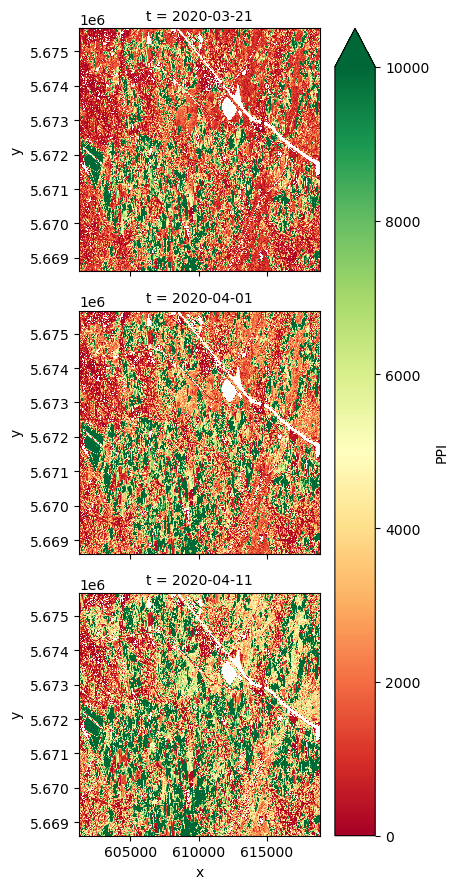

In [8]:
ds.PPI.plot(vmin=0, vmax=10000.0, cmap="RdYlGn", col="t", col_wrap=1)

## Point query
This example retrieves the PPI trajectory over time, using a point query.

We again use netCDF for download which simplifies manipulating and plotting the result as a proper timeseries.

More spatial aggregation examples:
https://open-eo.github.io/openeo-python-client/basics.html#aggregated-evi-timeseries


In [9]:
from shapely.geometry import Point

In [10]:
%%time
cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2018-01-15","2021-12-15"],bands=["PPI"])
cube.aggregate_spatial(Point(5.1032731,51.2644580),reducer="mean").download("eea_veg_ts.nc")

CPU times: user 24.2 ms, sys: 6.93 ms, total: 31.1 ms
Wall time: 41.9 s


In [11]:
ppi_timeseries = xr.open_dataset("eea_veg_ts.nc")
ppi_timeseries

<xarray.Dataset>
Dimensions:        (t: 141, feature: 1)
Coordinates:
  * t              (t) datetime64[ns] 2018-01-21 2018-02-01 ... 2021-12-11
    lat            (feature) float64 ...
    lon            (feature) float64 ...
    feature_names  (feature) object ...
Dimensions without coordinates: feature
Data variables:
    PPI            (feature, t) float64 ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.

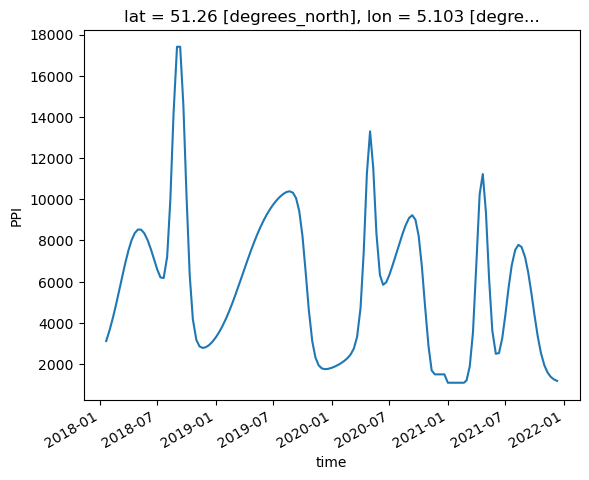

In [12]:
ppi_timeseries.PPI.plot()

## Spatial aggregation over a polygon

This example uses a polygon, which can correspond to an agricultural parcel. 
This time, we retrieve more than one statistic with the same call.

https://open-eo.github.io/openeo-python-client/basics.html#computing-multiple-statistics

In [13]:
import json
parcel = json.loads("""
{
    "type": "FeatureCollection",
    "features": [
        {
            "id": "0",
            "type": "Feature",
            "properties": {
                "id": 0
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            5.103273137658833,
                            51.2644580376614
                        ],
                        [
                            5.105770274251699,
                            51.26289548617123
                        ],
                        [
                            5.104640319943427,
                            51.262395458475154
                        ],
                        [
                            5.102249311655759,
                            51.26381739797543
                        ],
                        [
                            5.103273137658833,
                            51.2644580376614
                        ]
                    ]
                ]
            }
        }
    ]
}
""")

In [14]:
%%time
from openeo.processes import array_create, quantiles, mean, sd
cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2018-01-15","2020-12-15"],bands=["PPI"])

cube.aggregate_spatial(parcel,reducer=lambda pixels: array_create([quantiles(pixels,q=4), mean(pixels),sd(pixels)])).download("eea_veg_ts_full.csv")

CPU times: user 20.7 ms, sys: 293 µs, total: 21 ms
Wall time: 48.4 s


<Axes: xlabel='date'>

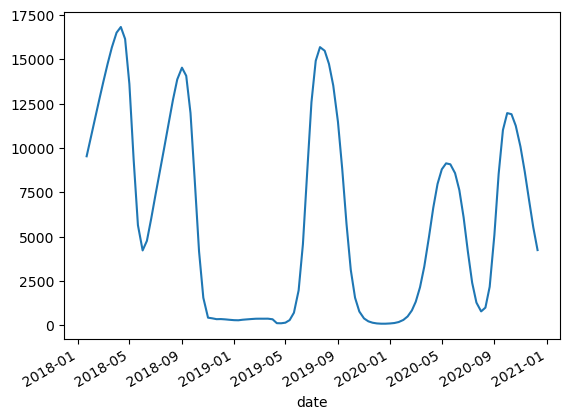

In [15]:
import pandas as pd
df = pd.read_csv("eea_veg_ts_full.csv",index_col=["date","feature_index"],parse_dates=['date']).sort_index()

df.xs(0, level='feature_index', drop_level=True)["avg(band_0)"].plot()

In [16]:
df

,,"percentile_approx(band_0, 0.25, 100000)","percentile_approx(band_0, 0.5, 100000)","percentile_approx(band_0, 0.75, 100000)",avg(band_0),stddev_samp(band_0)
date,feature_index,,,,,
2018-01-21 00:00:00+00:00,0,8837,10142,11043,9535.238095,2273.346300
2018-02-01 00:00:00+00:00,0,10072,11346,12190,10723.077922,2278.055831
2018-02-11 00:00:00+00:00,0,11327,12437,13176,11809.190476,2203.578429
2018-02-21 00:00:00+00:00,0,12432,13441,14151,12884.761905,2049.420629
2018-03-01 00:00:00+00:00,0,13369,14218,14812,13726.653680,1870.464395
...,...,...,...,...,...,...
2020-11-01 00:00:00+00:00,0,8339,10187,11688,10078.502165,2585.930783
2020-11-11 00:00:00+00:00,0,6952,8734,10166,8676.367965,2256.132651
2020-11-21 00:00:00+00:00,0,5699,7089,8385,7085.861472,1813.356417


## Masking by start of season

This is a more complex example that shows more advanced openEO capabilities:

* Turning a raster of SOSD values into a binary mask using logical operators
* Applying a mask to the PPI trajectory

In [17]:

sosd = connection.load_collection("VEGETATION_PHENOLOGY_AND_PRODUCTIVITY_PARAMETERS_SEASON_1",spatial_extent=spatial_extent,temporal_extent=["2019-01-01","2019-01-02"], bands=["SOSD"])


In [18]:
%%time
mask = ~((sosd.band("SOSD") >18800)  and  (sosd.band("SOSD") <19000))

cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2020-03-15","2020-04-15"],spatial_extent=spatial_extent, bands=["PPI"])
masked_cube = cube.mask(mask.max_time().resample_cube_spatial(cube))
masked_cube.download("eea_ppi_masked.nc")

CPU times: user 22.9 ms, sys: 6.3 ms, total: 29.2 ms
Wall time: 52.1 s


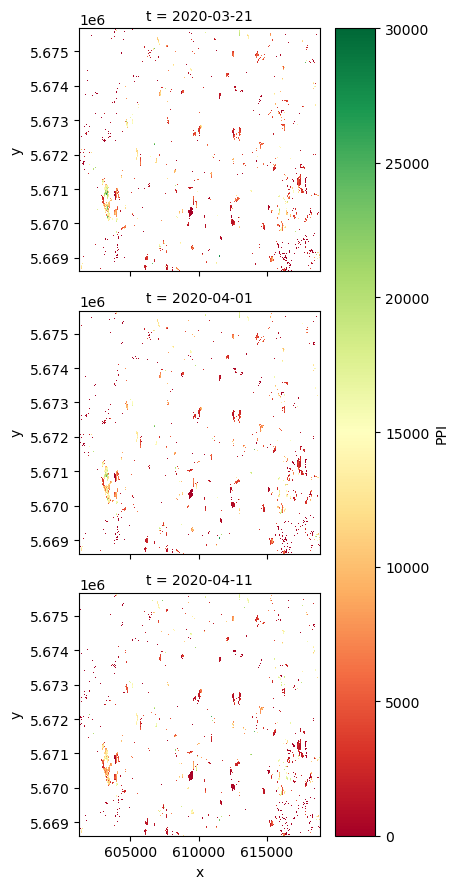

In [19]:
import xarray as xr
mask_ds = xr.open_dataset("eea_ppi_masked.nc")
mask_ds.PPI.plot(vmin=0, vmax=30000.0, cmap="RdYlGn", col="t", col_wrap=1)

## Aggregating over a larger area
Now that data is masked, we can also get a meaningfull average PPI over a larger area.

In [26]:
from shapely.geometry import box
cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2019-01-15","2021-04-15"],spatial_extent=spatial_extent, bands=["PPI"])
masked_cube = cube.mask(mask.max_time().resample_cube_spatial(cube))
masked_cube.aggregate_spatial(box(spatial_extent['east'],spatial_extent['south'],spatial_extent['west'],spatial_extent['north']),reducer="mean").execute_batch("aggregated_fields.csv")

0:00:00 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': send 'start'
0:00:19 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': queued (progress N/A)
0:00:25 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': queued (progress N/A)
0:00:32 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': queued (progress N/A)
0:00:41 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': queued (progress N/A)
0:00:52 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:01:04 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:01:20 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:01:40 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:02:04 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:02:34 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:03:11 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:03:58 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': running (progress N/A)
0:04:57 Job 'j-24eeb6bfbf9f439cb0411a9a0e4469cf': finished (progr

<BatchJob job_id='j-24eeb6bfbf9f439cb0411a9a0e4469cf'>

<Axes: xlabel='date'>

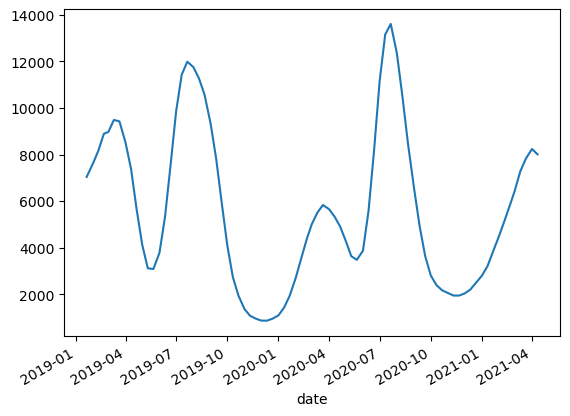

In [27]:
import pandas as pd
df = pd.read_csv("aggregated_fields.csv",index_col=["date","feature_index"],parse_dates=['date']).sort_index()

df.xs(0, level='feature_index', drop_level=True)["avg(band_0)"].plot()

In [28]:
df

,,avg(band_0)
date,feature_index,
2019-01-21 00:00:00+00:00,0,7037.599696
2019-02-01 00:00:00+00:00,0,7595.095536
2019-02-11 00:00:00+00:00,0,8160.188676
2019-02-21 00:00:00+00:00,0,8892.303610
2019-03-01 00:00:00+00:00,0,8968.397110
...,...,...
2021-03-01 00:00:00+00:00,0,6445.248073
2021-03-11 00:00:00+00:00,0,7278.505116
2021-03-21 00:00:00+00:00,0,7825.789146
